# Comparison of internal and external Dbit-seq experiments, xDbit experiments and experiments using characteristics of both methods

Experiments to compare:
1. Dbit-seq - first experiment - 37_13
2. SpatialMouse: 37_38 + 37_28 (not 37_46 since there the tissue was destroyed manually which had nothing to do with the method itself!)
3. Dbit-seq publication

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
## Import the custom library
import os
import sys

# add xDbit toolbox path to path variable
module_path = os.path.abspath("../../")
if module_path not in sys.path:
    sys.path.append(module_path)

import xdbit_funcs as db

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import seaborn as sns

### Functions

In [3]:
def calc_metrics(adata):
    adata.var['mt'] = adata.var_names.str.contains('MT-', case=False)  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [4]:
def violinplot(data, x, y, ax, order=None, ylabel="# of {} per spot", hue=None, jitter=0.4, hue_order=None,):
    # plotting
    sns.violinplot(x=x, y=y, data=data, ax=ax, hue=hue, inner=None, dodge=False, order=order, hue_order=hue_order)
    sns.stripplot(x=x, y=y, data=data, ax=ax, hue=None, size=1, color='black', dodge=True, jitter=jitter, order=order)
    
    # settings
    ax.set_ylim(0, None)
    ax.tick_params(axis='x', which='major', labelsize=16, rotation=45)
    ax.tick_params(axis='y', which='major', labelsize=16, rotation=0)
    ax.set_ylabel(ylabel.format(y), fontsize=16)
    
    # set legend
    legend = ax.legend(title="Method",
                       #loc="upper left",
                       #bbox_to_anchor=(1, 1.03),
                       fontsize=16)
    plt.setp(legend.get_title(),fontsize=16)
    
    plt.tight_layout()

### Read Dbit-seq experiment

In [5]:
dbitseq_file = "../source_data/37_13_DGE_matrix_with_introns_min100.txt.gz"

dbitseq = sc.read_text(dbitseq_file).transpose()

In [6]:
#### Calculate metrics

In [7]:
# calc metrics
calc_metrics(dbitseq)

# add additional parameters to obs
dbitseq.obs['id'] = "37_13"
dbitseq.obs['organ'] = "Liver"
dbitseq.obs['method'] = "Dbit-seq"

In [8]:
dbitseq

AnnData object with n_obs × n_vars = 2170 × 18707
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'id', 'organ', 'method'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Read first xDbit experiment 37_28 (on old liver)

In [9]:
dbitx_old_file = "../source_data/37_28_DGE_matrix_with_introns_min100.txt.gz"

dbitx_old = sc.read_text(dbitx_old_file).transpose()

#### Calculate metrics

In [10]:
# calc metrics
calc_metrics(dbitx_old)

# add additional parameters to obs
dbitx_old.obs['id'] = "37_28"
dbitx_old.obs['organ'] = "Liver"
dbitx_old.obs['method'] = "DbitX (simple)"

In [11]:
dbitx_old

AnnData object with n_obs × n_vars = 1906 × 26983
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'id', 'organ', 'method'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Read original Dbit-seq experiment

According to the table here, 0628 is a 50 µm experiment on E12: https://github.com/MingyuYang-Yale/DBiT-seq/tree/master/Pre-processing 

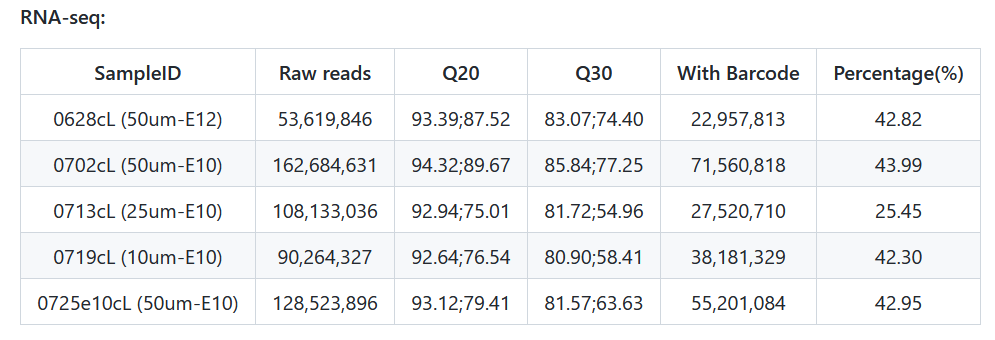

In [12]:
exp_files = {
    "E10": "../source_data/GSM4189613_0702cL.tsv.gz",
    "E12": "../source_data/GSM4189612_0628cL.tsv.gz"
}

orig_dbits = {key: sc.read_text(file) for key, file in exp_files.items()}

#### Calculate metrics

In [13]:
for key, elem in orig_dbits.items():
    # calc metrics
    calc_metrics(elem)
    
    # add parameters
    elem.obs['id'] = 'Liu, 2020 - {}'.format(key)
    elem.obs['organ'] = 'Embryo'
    elem.obs['method'] = 'Dbit-seq'

In [14]:
orig_dbits

{'E10': AnnData object with n_obs × n_vars = 901 × 22846
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'id', 'organ', 'method'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 'E12': AnnData object with n_obs × n_vars = 1667 × 22571
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'id', 'organ', 'method'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'}

### Read xDbit experiment

In [16]:
# directories
data_dir = "out/"

# get files
input_files = sorted(glob(os.path.join(data_dir, "*_clean_wohires.h5ad")))

# read files
perOrgan = {os.path.basename(f).split("_")[0]: sc.read(f) for f in input_files}

#### Calculate metrics

In [17]:
dbitx = []
for organ, a in perOrgan.items():
    # remove images to save memory
    db.tl.remove_images(a)
    
    # calc metrics and add identifier
    calc_metrics(a)
    a.obs['method'] = 'DbitX (multi)'
    
    # create list
    dbitx.append(a)

### Concatenate all experiments

In [18]:
adatas = dbitx + [dbitseq] + [dbitx_old] + list(orig_dbits.values())

counts_list = []
for ad in adatas:
    #key = "-".join(ad.obs[["id", "organ"]].values[0])
    idx = ad.obs["id"].values
    organ = ad.obs["organ"].values
    method = ad.obs["method"].values
    c = ad.obs["total_counts"].values
    g = ad.obs["n_genes_by_counts"].values
    
    d = pd.DataFrame({
        "id": idx,
        "organ": organ,
        "method": method,
        "counts": c,
        "genes": g})
    
    counts_list.append(d)

df = pd.concat(counts_list)

### Select experiments

In [19]:
# select experiments
selected = ["Liu, 2020 - E10", "Liu, 2020 - E12", "37_13", "37_28", "37_38_B2", "37_46_B3"]
data = df.loc[df["id"].isin(selected), :].copy()

# Normalization to Sequencing depth

Since the number of reads also depends on the sequencing depth that was used in the respective experiments, here we normalize to this sequencing depth.

In [20]:
# get read depth
readinfo = pd.read_excel("../source_data/ReadDepth_Dbit_Experiments.xlsx")
read_dict = {idx: readinfo.query('id == "{}"'.format(idx))['mil_seqs'].values[0] for idx in readinfo.id.unique()}

In [21]:
# normalize
data["mil_reads"] = [read_dict[idx] for idx in data["id"]]
data["counts_norm"] = [row["counts"] / row["mil_reads"] for i, row in data.iterrows()]
data["genes_norm"] = [row["genes"] / row["mil_reads"] for i, row in data.iterrows()]

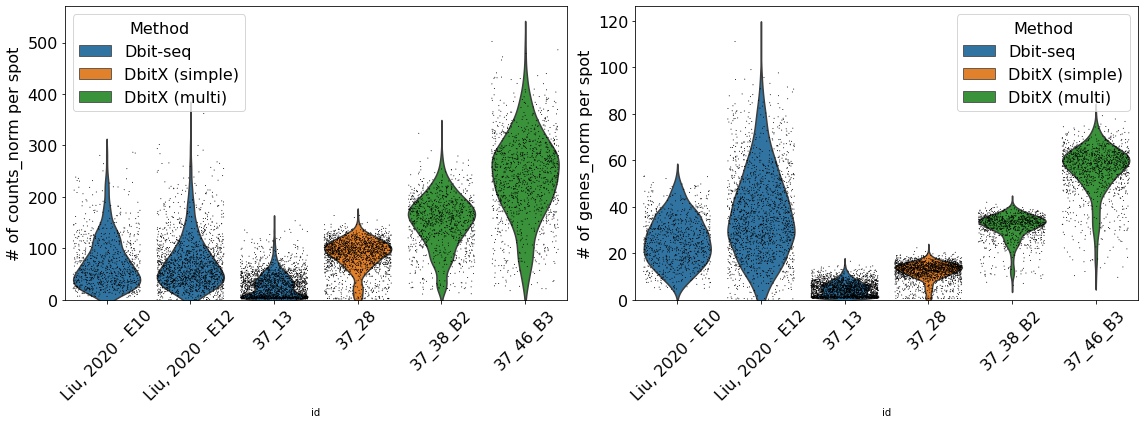

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(8*2, 6))

hue_order = ["Dbit-seq", "DbitX (simple)", "DbitX (multi)"]

violinplot(data=data, y='counts_norm', x='id', hue="method", ax=axs[0], order=selected, hue_order=hue_order)
violinplot(data=data, y='genes_norm', x='id', hue="method", ax=axs[1], order=selected, hue_order=hue_order)

plt.savefig("figures/violin_compare_experiments_norm.pdf")
plt.show()